# Temperature By Countries

In [3]:
%matplotlib inline
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn
from scipy import stats
from datetime import datetime
from math import *
from util import *

plt.rcParams["figure.figsize"] = (15, 8)

## Parseo datos

In [2]:
df = pd.read_csv('data/GlobalLandTemperaturesByCountry.csv', parse_dates=[0])
#Me quedo con las que la temperatura no esta vacia
df = df[df.AverageTemperature.notnull()]

#Nombre columnas: dt, AverageTemperature, AverageTemperatureUncertainty, Country

#Parseo las fechas. Estas no pueden ser un timestamp porque tenemos que operar con ellas (son los x)
# Esta dividido por 10000 para que quede el año como la parte entera y los graficos tengan los ejes con él
#df['dt']= df['dt'].apply(lambda x: float(x.translate({ord('-'): None})))
first_day = datetime(1743, 1, 1)
df['days']= df['dt'].apply(lambda x: (x - first_day).days)
print(df.head())


groupByCountries = df.groupby('Country')

          dt  AverageTemperature  AverageTemperatureUncertainty Country  days
0 1743-11-01               4.384                          2.294   Åland   304
5 1744-04-01               1.530                          4.680   Åland   456
6 1744-05-01               6.702                          1.789   Åland   486
7 1744-06-01              11.609                          1.577   Åland   517
8 1744-07-01              15.342                          1.410   Åland   547


## Test con los datos de Argentina

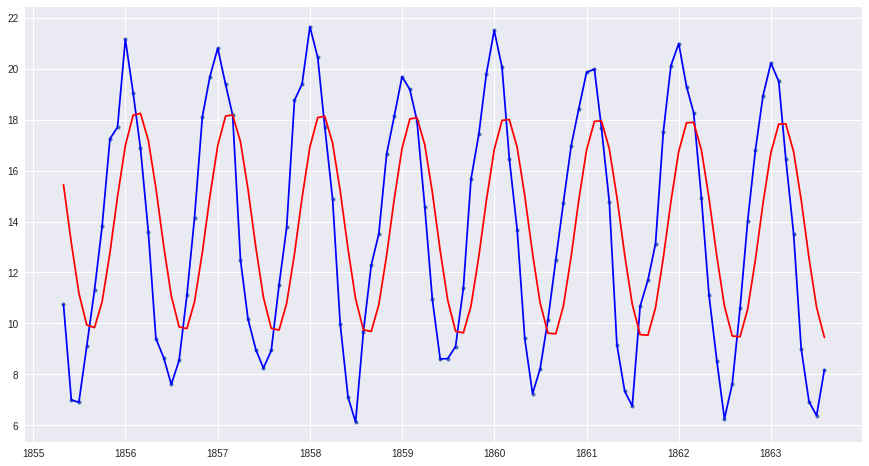

In [3]:
#Genero una especie de dataframe con los datos de argentina
ezeWants=100
gArg = groupByCountries.get_group('Argentina')
argFechas = list(gArg['days'][:ezeWants])
argTemp = list(gArg['AverageTemperature'][:ezeWants])

model = lambda x: [sin(x*2*pi/365 + 365/2), float(x), 1.0]

func = cml(model, argFechas, argTemp)
results = list(map(func, argFechas))
#print("ECM =", ecm(argFechas, results))

#loly = argTemp[:100]
#lolx = a[:100]
#func = cml(poly(9), lolx, loly)
#results2 = list(map(func, lolx))

#print("ECM = ", ecm(argFechas, results))

plt.plot(gArg["dt"][:ezeWants], argTemp, 'o', label='Temperatura', markersize=4)
plt.plot(gArg["dt"][:ezeWants], argTemp, 'r', label='Temperatura', markersize=4, color='blue')
plt.plot(gArg["dt"][:ezeWants], results, 'r', label='Temperatura', markersize=4, color='red')
#plt.plot(lolx, results2, 'r')
#plt.plot(a, argTemp, 'o', label='Temperatura', markersize=4)
#plt.plot(argFechas, results, 'r')
plt.show()

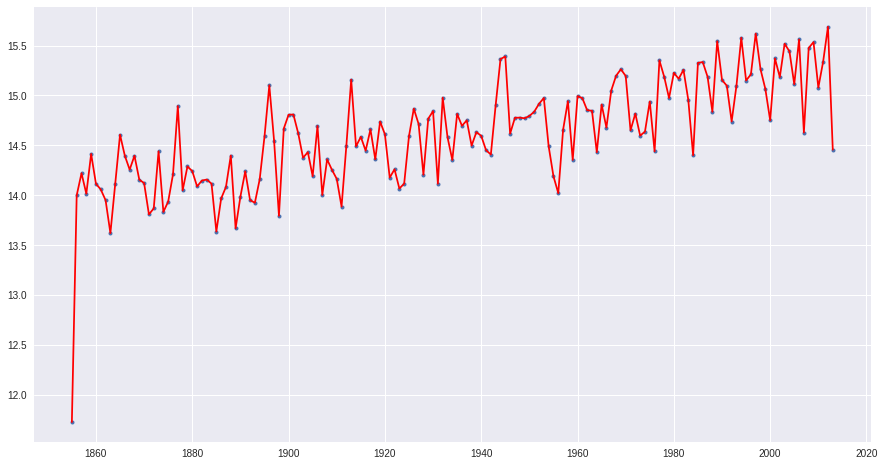

In [4]:
gArg2 = pd.DataFrame(gArg)
gArg2['year'] = gArg2["dt"].apply(lambda d: d.year)
gg = gArg2.groupby("year")["AverageTemperature"].agg(["mean", "count"])

plt.plot(gg.index, gg['mean'], 'o', label='Temperatura', markersize=4)
plt.plot(gg.index, gg['mean'], 'r', label='Temperatura', markersize=4)

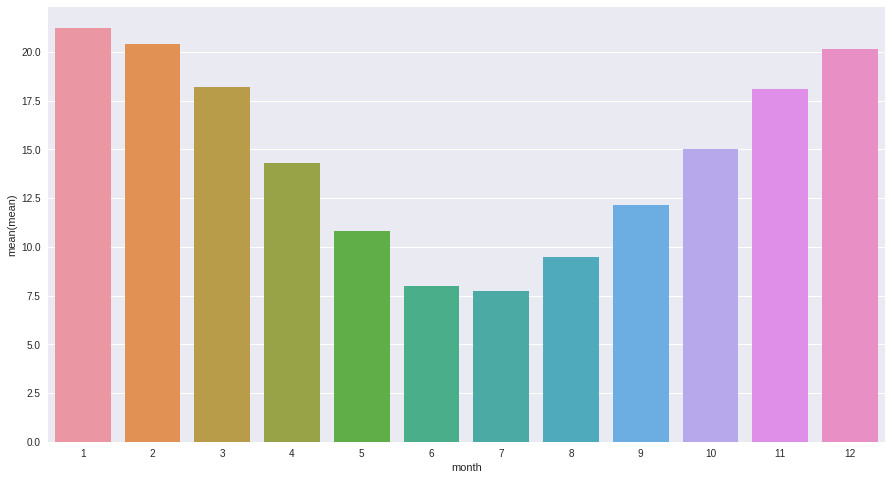

In [5]:
gArg2 = pd.DataFrame(gArg)
gArg2['month'] = gArg2["dt"].apply(lambda d: d.month)
gg = gArg2.groupby("month")["AverageTemperature"].agg(["mean", "count"])
gg["month"] = gg.index

sns.barplot(x="month", y="mean", data=gg)

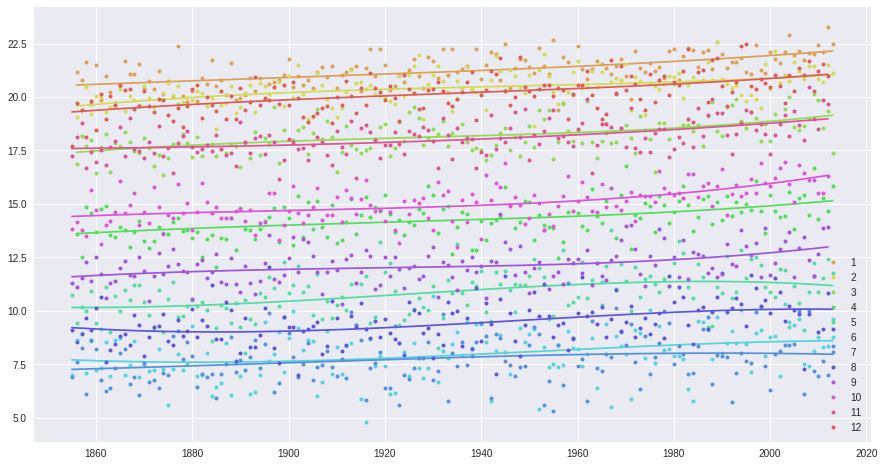

In [6]:
gArg2 = pd.DataFrame(gArg)
gArg2['month'] = gArg2["dt"].apply(lambda d: d.month)

p = sns.color_palette("hls", 12)


for x in range(1, 13):
    d = gArg2[gArg2["month"] == x]
    
    f = cml(poly(5), list(d["year"]), list(d["AverageTemperature"]))
    results = list(map(f, list(d["year"])))
    
    plt.plot(d["year"], d['AverageTemperature'], 'o', markersize=4, label=x, color=p[x % 12])
    plt.plot(d["year"], results, 'r', color=p[x % 12])
    
plt.legend()

# Busco correlaciones

In [12]:
df = pd.read_csv('data/GlobalLandTemperaturesByCountry.csv', parse_dates=[0])
df.columns = ['dt', 'avg', 'error', 'country']
df = df[df.avg.notnull()]
df.head()

,dt,avg,error,country
0,1743-11-01,4.384,2.294,Åland
5,1744-04-01,1.530,4.680,Åland
6,1744-05-01,6.702,1.789,Åland
7,1744-06-01,11.609,1.577,Åland
8,1744-07-01,15.342,1.410,Åland


### Calculo de estación.
Para esto calculamos el centroide del país. Luego vemos si el mismo esta por arriba o abajo del ecuador y obtenemos el hemisferio. Finalmente con mes y hemisferio tenemos la estación.

In [68]:
SPRING, SUMMER, FALL, WINTER = 1, 2, 3, 4
def get_season(row):
    north = row['hemisphere'] > 0
    month = row['month']
    if month in [12, 1, 2]:
        return WINTER if north else SUMMER
    elif month in [3, 4, 5]:
        return SPRING if north else FALL
    elif month in [6, 7, 8]:
        return SUMMER if north else WINTER
    elif month in [9, 10, 11]:
        return FALL if north else SPRING
    else:
        raise Exception('Unknown month.', row)
    
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world.set_index('name')
join = gpd.GeoDataFrame(df.join(world, on='country', how='inner'))
join['centroid'] = join.centroid
join['hemisphere'] = join['centroid'].apply(lambda p: 1 if p.y >= 0 else -1)
join['month'] = join['dt'].apply(lambda d: d.month)
join['season'] =  join.apply(get_season, axis=1)
join.head()

,dt,avg,error,country,pop_est,continent,iso_a3,gdp_md_est,geometry,centroid,hemisphere,month,season
3239,1838-04-01,13.008,2.586,Afghanistan,28400000.0,Asia,AFG,22270.0,"POLYGON ((61.21081709172574 35.65007233330923,...",POINT (66.08669022192834 33.85639928169076),1,4,1
3241,1838-06-01,23.950,2.510,Afghanistan,28400000.0,Asia,AFG,22270.0,"POLYGON ((61.21081709172574 35.65007233330923,...",POINT (66.08669022192834 33.85639928169076),1,6,2
3242,1838-07-01,26.877,2.883,Afghanistan,28400000.0,Asia,AFG,22270.0,"POLYGON ((61.21081709172574 35.65007233330923,...",POINT (66.08669022192834 33.85639928169076),1,7,2
3243,1838-08-01,24.938,2.992,Afghanistan,28400000.0,Asia,AFG,22270.0,"POLYGON ((61.21081709172574 35.65007233330923,...",POINT (66.08669022192834 33.85639928169076),1,8,2
3244,1838-09-01,18.981,2.538,Afghanistan,28400000.0,Asia,AFG,22270.0,"POLYGON ((61.21081709172574 35.65007233330923,...",POINT (66.08669022192834 33.85639928169076),1,9,3


### Veo el coeficiente de correlación entre algunas variables.

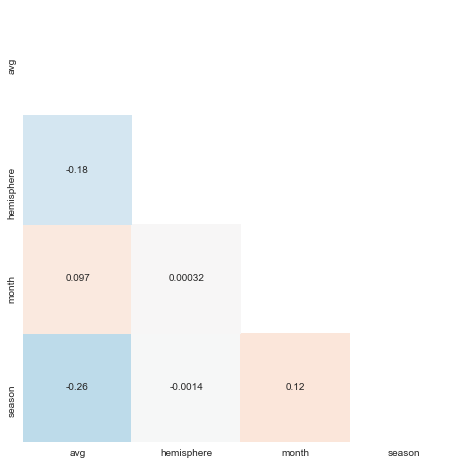

In [96]:
d = join[['avg', 'hemisphere', 'month', 'season']].as_matrix()
corr = np.corrcoef(d.T)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = 1

corr = pd.DataFrame(corr, columns=['avg', 'hemisphere', 'month', 'season'])
corr.index = ['avg', 'hemisphere', 'month', 'season']
with sns.axes_style("white"):
    sns.heatmap(corr, mask=mask, square=True, annot=True, cbar=False)

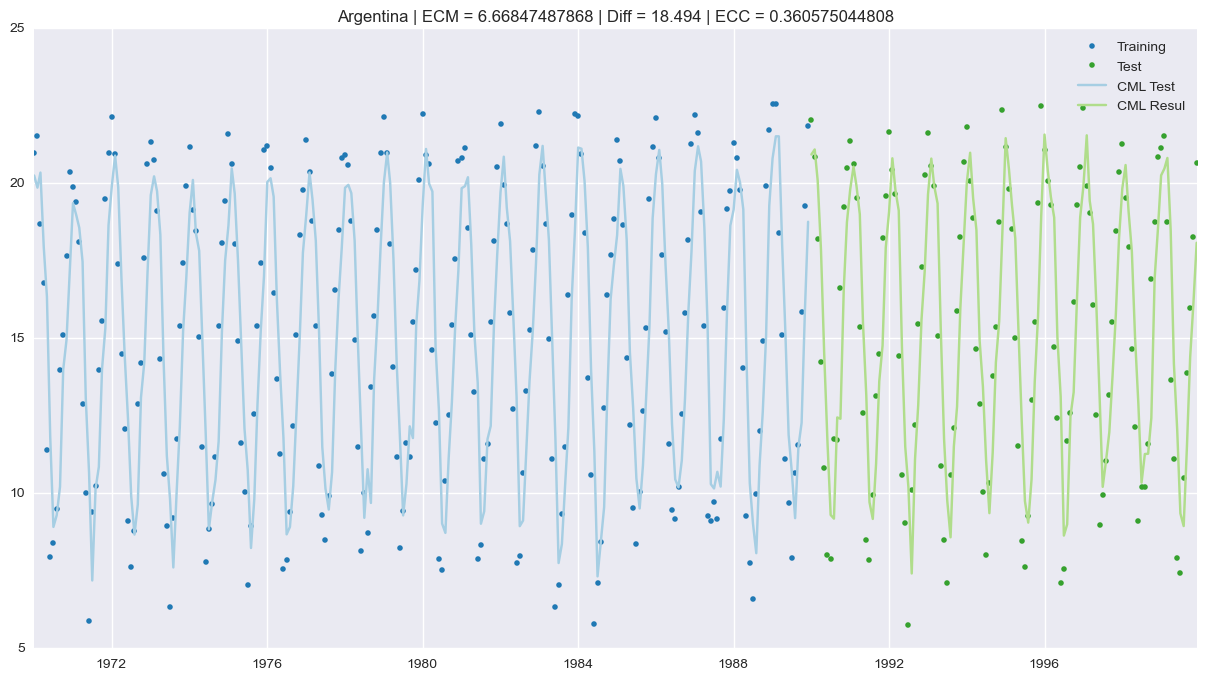

In [6]:
from datetime import datetime
palette = sns.color_palette('Paired')

def lol(country):
    df = pd.read_csv('data/GlobalLandTemperaturesByCountry.csv', parse_dates=[0])
    df.columns = ['dt', 'temp', 'error', 'country']
    df = df[df.temp.notnull()]
    df['date'] = df['dt'].apply(lambda d: d.toordinal())
    df = df[df['country'] == country]
    
    minmax = df.groupby('country')['temp'].aggregate(['max', 'min'])
    diff = minmax.loc[country]['max'] - minmax.loc[country]['min'] 
    
    # calculo el shift
    df['prev1'] = df['temp'].shift(1)
    df['prev2'] = df['temp'].shift(2)
    df = df[2:]

    df_t = df[df['dt'] < datetime(1990, 1, 1)]
    df_t = df_t[df_t['dt'] >= datetime(1970, 1, 1)]

    df_r = df[df['dt'] >= datetime(1990, 1, 1)]
    df_r = df_r[df_r['dt'] < datetime(2000, 1, 1)]

    xs = df_t[['date', 'prev1', 'prev2']].as_matrix()

    f = cml(lambda x: [1, x[0], x[1]], xs, df_t['temp'])
    results_t = list(map(f, df_t[['date', 'prev1', 'prev2']].as_matrix()))
    results_r = list(map(f, df_r[['date', 'prev1', 'prev2']].as_matrix()))

    plt.plot(df_t['dt'], df_t['temp'], 'o', label='Training', markersize=4, color=palette[1])
    plt.plot(df_r['dt'], df_r['temp'], 'o', label='Test', markersize=4, color=palette[3])

    plt.plot(df_t['dt'], results_t, 'r', label='CML Test', color=palette[0])
    plt.plot(df_r['dt'], results_r, 'r', label='CML Resul', color=palette[2])
    plt.legend()
    ecm_error = ecm(results_r, df_r['temp'])
    ecm_norm = ecm_error/diff
    plt.title('{} | ECM = {} | Diff = {} | ECC = {}'.format(country, ecm_error, diff, ecm_norm))
    plt.show()
    
for x in ['Argentina']:
    lol(x)